In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def preprocess(batch_images):
    gray_images = tf.image.rgb_to_grayscale(batch_images)
    binary_images = tf.where(gray_images > 127, 255, 0)
    rgb_images = tf.image.grayscale_to_rgb(binary_images)

    # standard aug
    K = 4
    datagen = ImageDataGenerator(width_shift_range = [-K, K], height_shift_range = [-K, K], horizontal_flip = True)
    standard_images = datagen.flow(rgb_images)

    return standard_images

In [3]:
# K = 4

# datagen = ImageDataGenerator(width_shift_range = [-K, K], height_shift_range = [-K, K], horizontal_flip = True)

# TRAIN_DATA = datagen.flow(X_TRAIN_SAMPLED, Y_TRAIN_SAMPLED, batch_size = 64)
# standard_history = model.fit(TRAIN_DATA, epochs=10, validation_data=(X_TEST, Y_TEST))

In [4]:
# dataset_dir = '/Users/terencemui/Documents/CS228/manuscript/dataset'
dataset_dir = './dataset'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir + "/train",
    image_size = (32, 32),
    label_mode='int',
    shuffle=True,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir + "/test",
    image_size = (32, 32),
    label_mode='int',
    shuffle=True,
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir + "/validation",
    image_size = (32, 32),
    label_mode='int',
    shuffle=True,
)

TRAIN_X = []
TRAIN_Y = []

for images, labels in train_dataset:
    TRAIN_X.append(images.numpy())
    TRAIN_Y.append(labels.numpy())

TRAIN_X = np.concatenate(TRAIN_X, axis=0)
TRAIN_Y = np.concatenate(TRAIN_Y, axis=0)

VAL_X = []
VAL_Y = []

for images, labels in val_dataset:
    VAL_X.append(images.numpy())
    VAL_Y.append(labels.numpy())

VAL_X = np.concatenate(VAL_X, axis=0)
VAL_Y = np.concatenate(VAL_Y, axis=0)

K = 4
datagen = ImageDataGenerator(width_shift_range = [-K, K], height_shift_range = [-K, K], horizontal_flip = True)
TRAIN_DATA = datagen.flow(TRAIN_X, TRAIN_Y, batch_size = 128)

# processed_train_dataset = train_dataset.map(lambda x, y: (preprocess(x), y))
# processed_test_dataset = test_dataset.map(lambda x, y: (preprocess(x), y))
# processed_val_dataset = val_dataset.map(lambda x, y: (preprocess(x), y))
# train_dataset = train_dataset.map(lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x), y))
# test_dataset = test_dataset.map(lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x), y))
# val_dataset = val_dataset.map(lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x), y))

Found 72609 files belonging to 93 classes.


2024-12-03 01:33:37.961492: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-03 01:33:37.961524: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-03 01:33:37.961527: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-03 01:33:37.961559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-03 01:33:37.961571: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 20719 files belonging to 93 classes.
Found 10463 files belonging to 93 classes.


2024-12-03 01:33:41.225996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-03 01:33:41.729481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
def label_to_ascii(label):
    if label < 27:
        return label + 100
    elif label < 86:
        return label + 6
    else:
        return label + 7

(32, 32, 3)
4 M


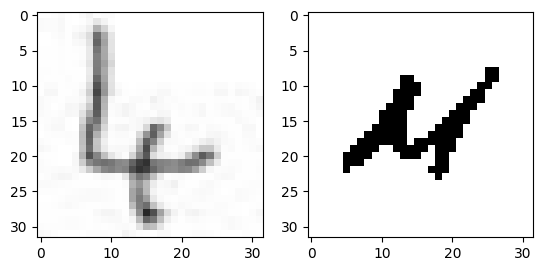

In [16]:
for original, processed in zip(train_dataset.take(1), processed_train_dataset.take(1)):
    plt.subplot(1, 2, 1)
    # plt.imshow(image[0].numpy().astype('uint8'))
    plt.imshow(original[0][0].numpy().astype('uint8'))
    plt.subplot(1, 2, 2)
    print(processed[0][0].shape)
    plt.imshow(processed[0][0], cmap="gray")
    # print(original[1][0], processed[1][0])
    print(chr(label_to_ascii(original[1][0])), chr(label_to_ascii(processed[1][0])))
    # print(chr(label_to_ascii(label[0])), image[0].shape)

In [ ]:
# create checkpoints
# checkpoint_path = "checkpoint_custom/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=False,
#                                                  verbose=1)

base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(32, 32, 3),
)

# Add custom classification layers
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(93, activation='softmax')(x)  # Your 93 classes
model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

# try:
#     model.load_weights(checkpoint_path)
#     print("loaded weights")
# except:
#     print("weights not found")

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(TRAIN_DATA, epochs=10, verbose=1, validation_data=(VAL_X, VAL_Y), batch_size = 128)

model.save_weights("/Users/terencemui/Documents/CS228/manuscript/weights/")

Epoch 1/10


/Users/shahdivyank/Desktop/CS228/.conda/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-12-03 01:33:53.509694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 44/568 ━━━━━━━━━━━━━━━━━━━━ 5:57 682ms/step - accuracy: 0.0877 - loss: 4.7513

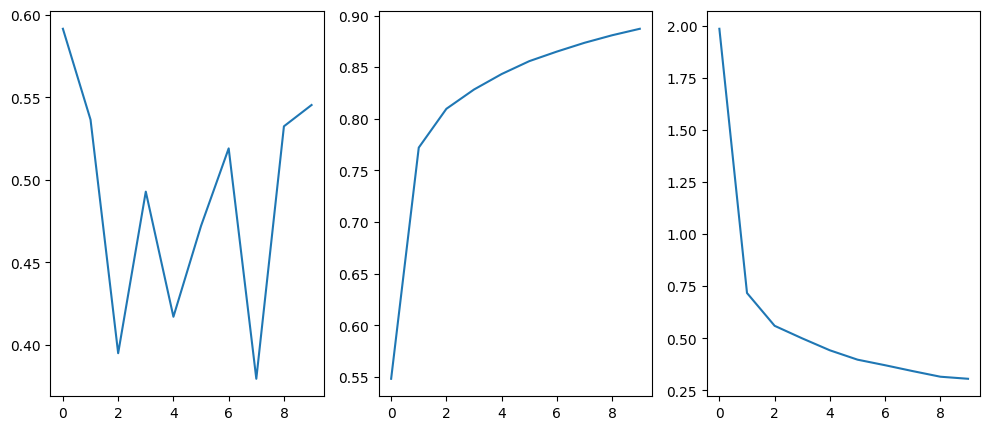

In [ ]:
custom_history = history
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(custom_history.history['val_accuracy'])
plt.subplot(1, 3, 2)
plt.plot(custom_history.history['accuracy'])
plt.subplot(1, 3, 3)
plt.plot(custom_history.history['loss'])